**`Description`**

- This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) to predict the closing stock price of a corportion (Apple Inc.) using the past 60 days stock price.

In [1]:
## Import Libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [2]:
## Get the stock quote
data = web.DataReader('AAPL', data_source='yahoo', start='2015-01-01', end='2019-12-31')

## show data
data.tail(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-17,281.769989,278.799988,279.570007,280.410004,28539600.0,278.990875
2019-12-18,281.899994,279.119995,279.799988,279.739990,29007100.0,278.324249
2019-12-19,281.179993,278.950012,279.500000,280.019989,24592300.0,278.602814
2019-12-20,282.649994,278.559998,282.230011,279.440002,68994500.0,278.025757
2019-12-23,284.250000,280.369995,280.529999,284.000000,24643000.0,282.562683
2019-12-24,284.890015,282.920013,284.690002,284.269989,12119700.0,282.831299
2019-12-26,289.980011,284.700012,284.820007,289.910004,23280300.0,288.442780
2019-12-27,293.970001,288.119995,291.119995,289.799988,36566500.0,288.333313
2019-12-30,292.690002,285.220001,289.459991,291.519989,36028600.0,290.044617


In [0]:
## check for "Date" column
# type(data["Date"][0]) ## --> "Date" is not column

In [4]:
## Get the number of rows and columns in the dtaa set
data.shape

(1258, 6)

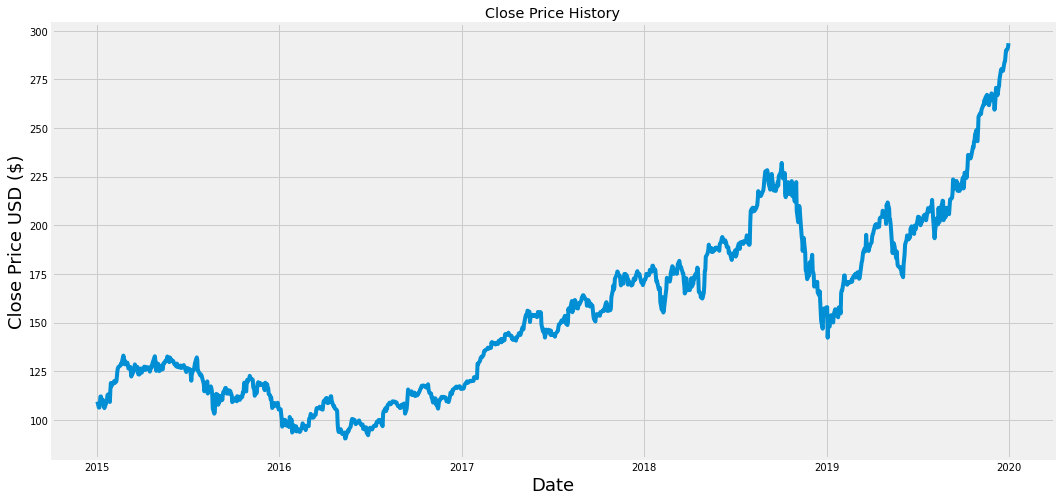

In [5]:
## Visualize closing price history
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(data["Close"])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [6]:
## Create a new dataframe with only the "Close" column
df = data.filter(["Close"])
display(df.head(15))

,Close
Date,
2015-01-02,109.330002
2015-01-05,106.250000
2015-01-06,106.260002
2015-01-07,107.750000
2015-01-08,111.889999
2015-01-09,112.010002
2015-01-12,109.250000
2015-01-13,110.220001
2015-01-14,109.800003


In [7]:

## check for available date before slicing
print(len(df), "\n")


## Convert the dataframe to a numpy array
dataset = df.values
print("\ndataframe to a numpy array:\n", dataset)

## Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.67)
print("\nNo. of training rows: ", training_data_len)

## Split data into training and testing
data_train = dataset[0:training_data_len, :].copy()
print("\nShape of Training Data: ", data_train.shape)
data_test = dataset[training_data_len : len(dataset)].copy()
print("\nShape of Testing Data: ", data_test.shape)


1258 


dataframe to a numpy array:
 [[109.33000183]
 [106.25      ]
 [106.26000214]
 ...
 [289.79998779]
 [291.51998901]
 [293.6499939 ]]

No. of training rows:  843

Shape of Training Data:  (843, 1)

Shape of Testing Data:  (415, 1)


In [0]:
## Scale the train data
scaler = MinMaxScaler(feature_range=(0,1))
data_train = scaler.fit_transform(data_train)
# print(data_train)

In [9]:
data_train.shape[0]

843

In [0]:
## Create the training dataset for the LSTM model
X_train = []
y_train = []

for i in range(60, data_train.shape[0]):
    X_train.append(data_train[i-60:i, 0]) # first 60 rows 0 to 59
    y_train.append(data_train[i, 0]) # 61st value i.e. 60
    # if i<=60:
    #     print(X_train)
    #     print(y_train)
    #     print()
    # if i<=61:
    #     print(X_train)
    #     print(y_train)
    #     print()


In [11]:
## Convert the x_train and y_train to numpy arrays

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)
print(X_train.shape[0], y_train.shape[0])

(783, 60) (783,)
783 783


In [12]:
## Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# here, 783 is no. of rows, 60 is no. of timestamp, 1 is no. of feature i.e. just the close column
print(X_train.shape)

(783, 60, 1)


In [13]:
X_train.shape[1]

60

In [0]:
## Build the LSTM model
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1))) # 50 is no. of neurons
model.add(LSTM(50, return_sequences=False)) ## False because we are not going to use LSTM model later

model.add(Dense(25))
model.add(Dense(1))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
## Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
## Train the model
model.fit(X_train, y_train, batch_size=3, epochs=2)
# batch_size is the total number of training example present in the single batch
# epochs is the number of iteration when the entire dataset is passed forward and backward through a neural network

Epoch 1/2
783/783 [==============================] - 14s 17ms/step - loss: 0.0064
Epoch 2/2
783/783 [==============================] - 13s 16ms/step - loss: 0.0020


## Test Data Preparation


In [30]:
## Convert
data_test = pd.DataFrame(data=data_test)
display(data_test.head())
print(data_test.shape)

,0
0,162.710007
1,164.339996
2,167.369995
3,172.990005
4,172.429993


(475, 1)


In [0]:
data_train = pd.DataFrame(data=data_train)
# display(data_train.tail(60))

In [0]:
## Last 60 days of data in training data
past_60_days = data_train.tail(60)

## Append data_test in past_60_days
df_test = past_60_days.append(data_test, ignore_index=True)
# df_test

In [44]:
## Scale the test data
df_test = scaler.transform(df_test)
df_test.shape

(535, 1)

In [0]:
## Create the testing dataset for the LSTM model prediction
X_test = []
y_test = []

for i in range(60, df_test.shape[0]):
    X_test.append(df_test[i-60:i])
    y_test.append(df_test[i, 0])

In [46]:
## Convert the x_train and y_train to numpy arrays

X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape, y_test.shape)
print(X_test.shape[0], y_test.shape[0])

(475, 60, 1) (475,)
475 475


In [47]:
## Reshape the data
X_test= np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# here, 475 is no. of rows, 60 is no. of timestamp, 1 is no. of feature i.e. just the close column
print(X_test.shape)

(475, 60, 1)


In [0]:
## Prediction
y_pred = model.predict(X_test)
# y_pred

## unscaling the values to see the exact closing price
y_pred = scaler.inverse_transform(y_pred)

In [53]:
## Evaluate the model
## Get the root mean square error (RMSE)
rmse = np.sqrt(np.mean(y_pred - y_test) ** 2)
rmse

12.370321743576195

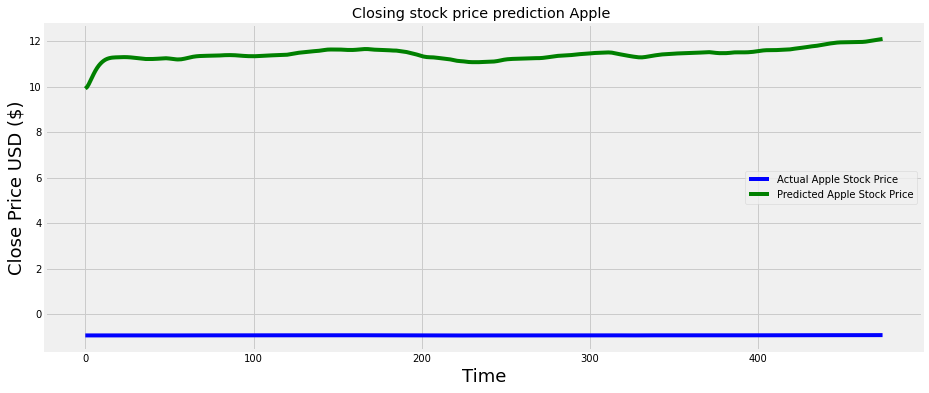

In [54]:
### Visualization
plt.figure(figsize=(14, 6))
plt.title('Closing stock price prediction Apple ')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(y_test, color = 'blue', label = "Actual Apple Stock Price")
plt.plot(y_pred, color = 'green', label = "Predicted Apple Stock Price")
plt.legend()
plt.show()

In [55]:
y_test

array([-0.9359926 , -0.93581466, -0.93548389, -0.93487038, -0.93493151,
       -0.93499483, -0.93507998, -0.93492387, -0.93459637, -0.93421757,
       -0.93428089, -0.93431036, -0.93465096, -0.93451887, -0.93445227,
       -0.93446865, -0.93464768, -0.93443917, -0.93410731, -0.93391736,
       -0.9341084 , -0.93427543, -0.9342525 , -0.93432128, -0.93461821,
       -0.93462476, -0.93505814, -0.93532232, -0.93574916, -0.93489439,
       -0.935378  , -0.93558105, -0.93543913, -0.93555921, -0.93537254,
       -0.93502103, -0.93489112, -0.93537363, -0.93519132, -0.934842  ,
       -0.93493042, -0.93474484, -0.93468043, -0.93456144, -0.93429726,
       -0.93434093, -0.93489112, -0.93566401, -0.93571641, -0.93596749,
       -0.93588998, -0.93582776, -0.93603517, -0.93571423, -0.93529503,
       -0.93447957, -0.93444463, -0.93368702, -0.93354183, -0.93344468,
       -0.93330167, -0.93300911, -0.9331674 , -0.93321543, -0.9334021 ,
       -0.93321216, -0.93334206, -0.93341629, -0.9332722 , -0.93